<img src="http://www.finanze.gov.it/export/system/modules/it.gov.finanze.template/resources/img/logo-mef.gif"  style="float: left; width: 25%; margin-left: 8%; margin-top: 0.5em;">

<img src="http://www.opencoesione.gov.it/static/img/header/testata.png" style="float: right; width: 42%; margin-right: 8%; margin-top: 1.6em;">

<p style="clear: both;">

# Studio a livello comunale sui finanziamenti a enti privati da dati OpenCoesione

### Obiettivi 
Questo studio si propone come esempio delle seguenti opportunita' offerte dal Data Analytics Framework (DAF):
 - Integrare dati da fonti diverse permette di compiere analisi piu' complete e semplici
 - L'uso di strumenti open-source consente di impiegare le piu' recenti ed avanzate tecniche di analisi ...

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc #garbage collector
from matplotlib import pyplot as plt

## Caricamento dataset da integrare

In [2]:
# --- Spese e redditi da OpenCivitas
speseERedditiComune = pd.read_csv('../opencivitas/data/opencivitas_spesa_storica_dati_irpef.csv') #dati per anno
speseERedditiComune = speseERedditiComune[~speseERedditiComune['Codice Istat Comune'].isna()]
speseERedditiComune['Codice Istat Regione'] = speseERedditiComune['Codice Istat Regione'].astype(int)

padZeros = np.vectorize(lambda x: str(x).rjust(6, '0')) # some utils
speseERedditiComune['Codice Istat Lungo'] = \
(speseERedditiComune['Codice Istat Regione'].astype(str) + padZeros(speseERedditiComune['Codice Istat Comune'].astype(int))).astype(int)

# --- Soggetti e luoghi da OpenCoesione
soggettiLuoghi = pd.read_csv('../pac_opencoesione/SoggettiELuoghi.csv', low_memory=False)
soggettiLuoghi.drop(columns=['SOGG_COD_RUOLO', 'SOGG_PROGR_RUOLO'], inplace=True)
soggettiLuoghi = soggettiLuoghi[~soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.isna()]
assert not any(soggettiLuoghi['COD_COMUNE_SEDE_SOGG'].isna()), 'Unexpected missing codes'
soggettiLuoghi['COD_COMUNE_SEDE_SOGG'] = soggettiLuoghi['COD_COMUNE_SEDE_SOGG'].astype(int)
soggettiLuoghi['COD_COMUNE_LUOGO'] = soggettiLuoghi['COD_COMUNE_LUOGO'].fillna(value=-1).astype(int)

## Integrazione OpenCoesione and OpenCivitas

#### Estrazione fondi erogati a soggetti privati per cui la sede e' riferibile ad un Comune:

In [3]:
bEntePrivato = soggettiLuoghi.COD_FORMA_GIURIDICA_SOGG.str.startswith('1') & \
                    (soggettiLuoghi.COD_COMUNE_SEDE_SOGG != -1)

soggLuoghiPrivato = soggettiLuoghi[bEntePrivato]
fondiSoggetti = soggLuoghiPrivato.groupby(
                    'COD_COMUNE_SEDE_SOGG')['TOT_PAGAMENTI'].sum().sort_values(ascending=False).to_frame()
fondiSoggetti = fondiSoggetti[fondiSoggetti >0]

#### In OpenCivitas non vi sono dati solo per le 15 regioni a Statuto ordinario: controlliamo quanto e' grande la quota di fondi in OpenCoesione riferita a sedi soggetto mancanti in OpenCivitas

In [4]:
listaComuniOpenCiv = speseERedditiComune['Codice Istat Lungo'].drop_duplicates()
listaRegioniOpenCiv = speseERedditiComune[['Codice Istat Regione', 'Regione']].drop_duplicates()
print(listaRegioniOpenCiv.set_index('Codice Istat Regione').sort_values('Regione'))
print('''
Il totale dei fondi verso soggetti privati con Comune della sede disponibile nei dati è EUR %.4g, 
            di cui %.4g corrispondono a comuni in OpenCivitas) 
            
        ''' % (fondiSoggetti.sum(),
                fondiSoggetti[fondiSoggetti.index.isin(listaComuniOpenCiv.values)].sum()))

unioneComuniSoggetti = pd.merge(speseERedditiComune, fondiSoggetti,
                                how='left',left_on='Codice Istat Lungo', right_index = True)


                             Regione
Codice Istat Regione                
13                           ABRUZZO
17                        BASILICATA
18                          CALABRIA
15                          CAMPANIA
8                     EMILIA-ROMAGNA
12                             LAZIO
7                            LIGURIA
3                          LOMBARDIA
11                            MARCHE
14                            MOLISE
1                           PIEMONTE
16                            PUGLIA
9                            TOSCANA
10                            UMBRIA
5                             VENETO

Il totale dei fondi verso soggetti privati con Comune della sede disponibile nei dati è EUR 1.359e+10, 
            di cui 1.222e+10 corrispondono a comuni in OpenCivitas) 
            
        


In [5]:
# Plot preparation
plt.rcParams["figure.figsize"] = (18,12)
#plt.rcParams.update({'font.size': 16})
sns.set_context("talk")
dataLog=unioneComuniSoggetti[unioneComuniSoggetti.ANNO==2013].copy()
dataLog['TOT_PAGAMENTI'] = np.log10(dataLog.TOT_PAGAMENTI)
dataLog['SPESA_CCC_tot'] = np.log10(dataLog.SPESA_CCC_tot)
xLabelLog = 'Log della spesa totale del Comune nel 2013'
yLabelLog = 'Log Totale Pagamenti da fondi Coesione ad enti privati nel Comune'

#### Plot dispersione complessiva e fit lineare per ciascuna Regione

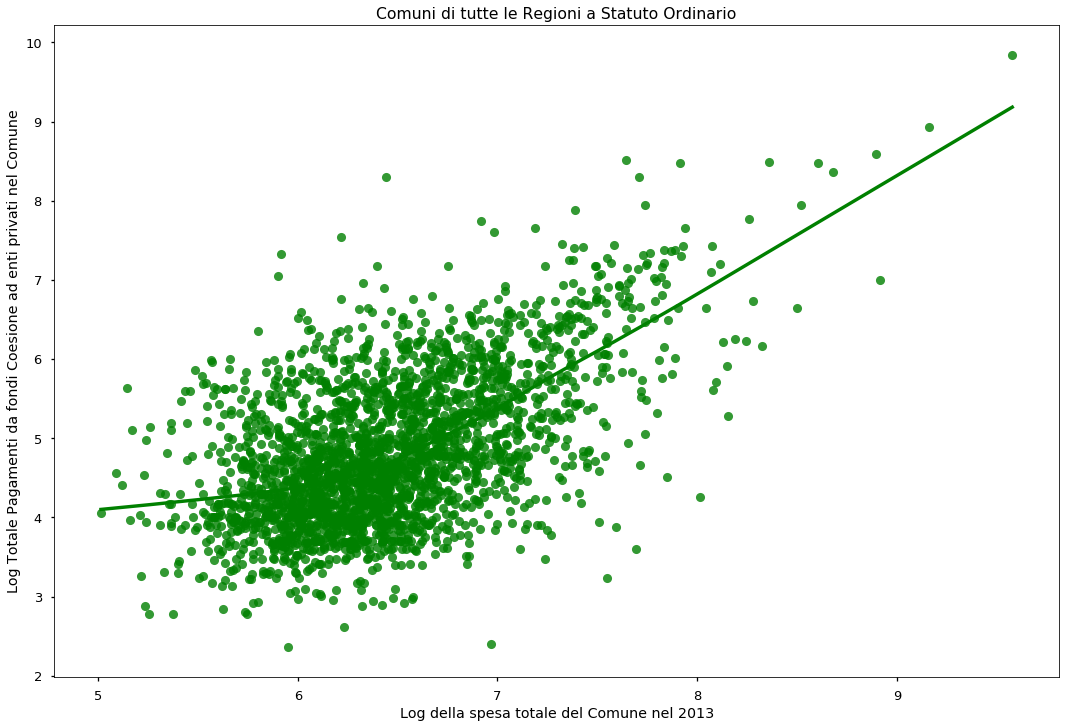

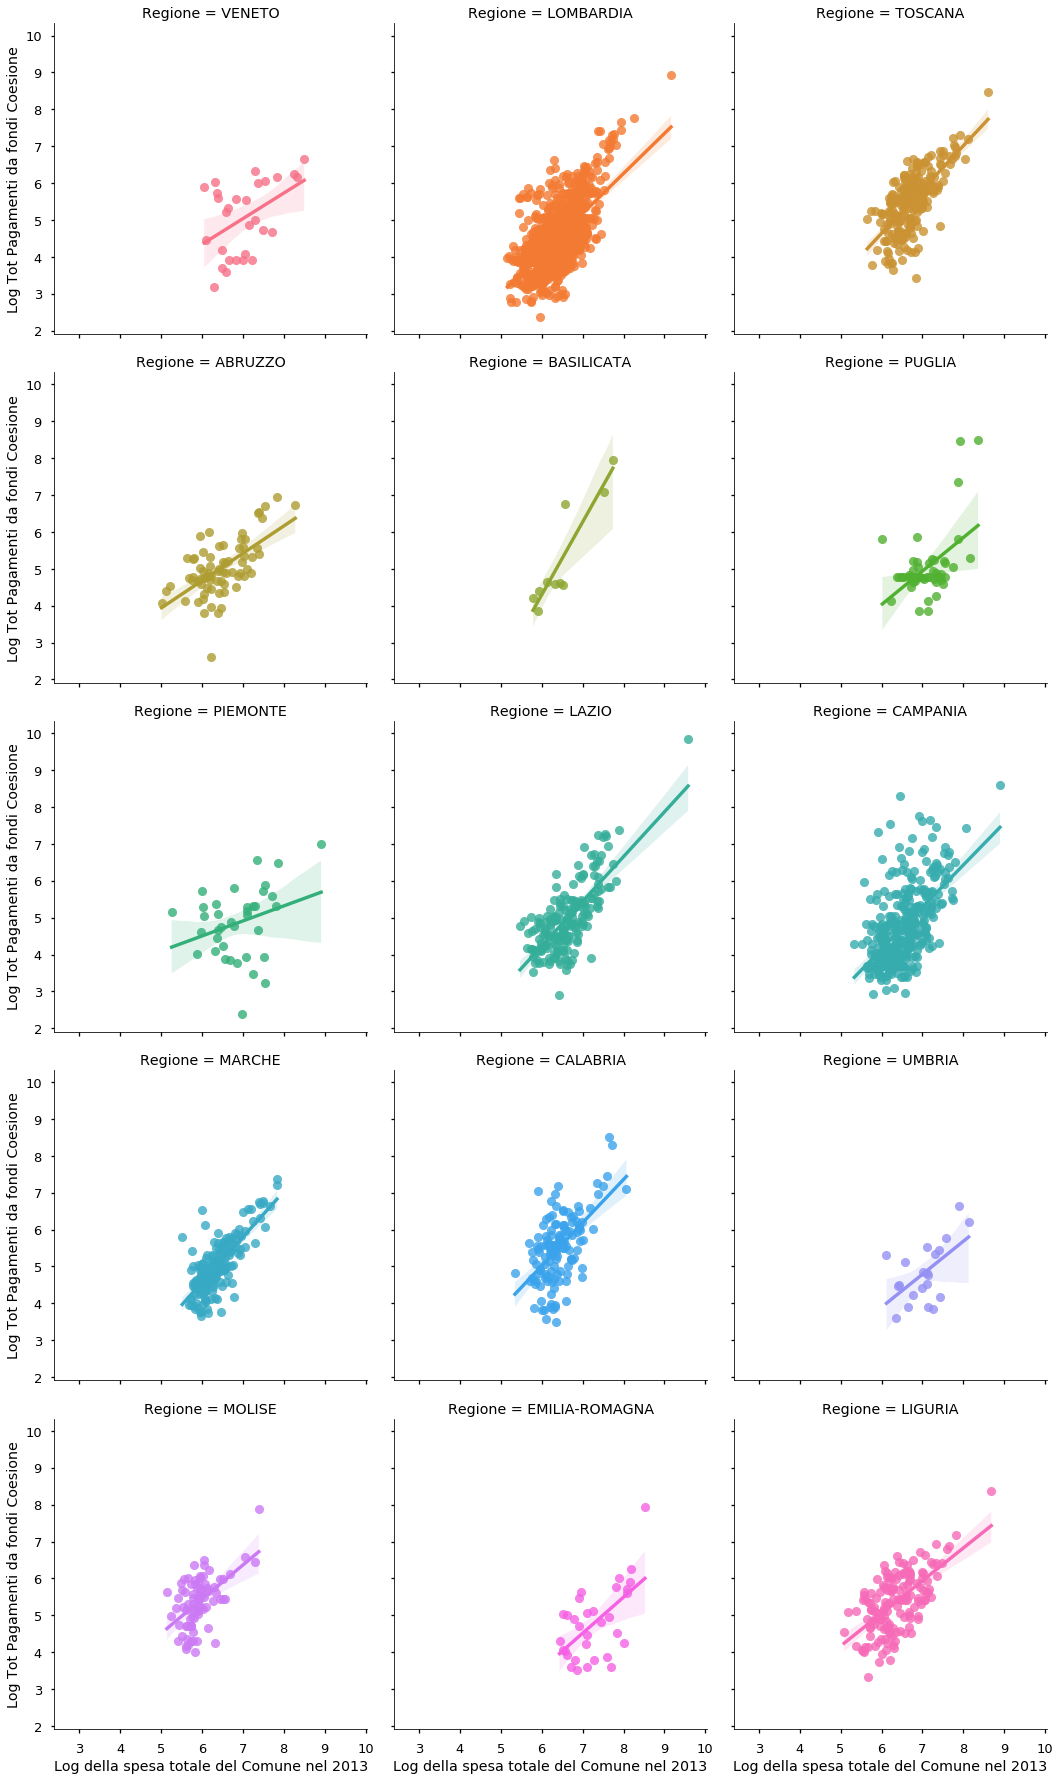

In [29]:
axAll = sns.regplot(x='SPESA_CCC_tot', y='TOT_PAGAMENTI', data=dataLog, lowess=True, color = 'g')
axAll.set(xlabel =xLabelLog, ylabel=yLabelLog, title='Comuni di tutte le Regioni a Statuto Ordinario')
axSplit = sns.lmplot(x='SPESA_CCC_tot', y='TOT_PAGAMENTI', data=dataLog, 
                    truncate=True, hue='Regione', col='Regione', col_wrap=3)
for ax in axSplit.axes:
    if ax.get_xlabel(): ax.set(xlabel=xLabelLog)
    if ax.get_ylabel(): ax.set(ylabel='Log Tot Pagamenti da fondi Coesione') 
plt.show()


In [7]:
dataLog['Numero contribuenti']

20100    14238.0
20101      212.0
20102     2457.0
20103     4998.0
20104      305.0
20105    22877.0
20106      546.0
20107     1028.0
20108     1658.0
20109      146.0
20110     1409.0
20111      289.0
20112      468.0
20113     1745.0
20114     1987.0
20115    28082.0
20116       84.0
20117      203.0
20118      775.0
20119     1068.0
20120     3226.0
20121     2204.0
20122      919.0
20123     4175.0
20124     1142.0
20125     2995.0
20126     1635.0
20127     2324.0
20128     3351.0
20129     2752.0
          ...   
26769    39974.0
26770    23915.0
26771    28091.0
26772     2252.0
26773      306.0
26774     5321.0
26775     1758.0
26776     3131.0
26777     1673.0
26778     4628.0
26779     3808.0
26780     1486.0
26781     1901.0
26782     2203.0
26783     2108.0
26784    24420.0
26785     5901.0
26786     3303.0
26787     4744.0
26788     2287.0
26789     7501.0
26790     8694.0
26791    46815.0
26792     7819.0
26793     6323.0
26794     1285.0
26795     1253.0
26796    10279